# Covertype

In [4]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice
    
key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split

from functools import partial
import kernels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Data

In [5]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

num_features = features.shape[-1]
num_classes = len(onp.unique(labels))

In [6]:
def get_batches(x, y, n_steps=500, batch_size=100):
    """Split x and y into batches"""
    assert len(x) == len(y)
    batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
    return islice(batch_cycle, n_steps)

num_batches = len(x_train) // 100

In [7]:
batches = get_batches(x_train, y_train, batch_size=5)

# dlnprob

In [10]:
class BayesLR:
    def __init__(self, X, Y, a0, b0):
        self.X, self.Y = X, Y
        self.a0, self.b0 = a0, b0
    
    def dlnprob(self, theta):
        ridx = random.permutation(subkey, self.X.shape[0])[:100]
        Xs = self.X[ridx, :] # batches
        Ys = self.Y[ridx]

        w = theta[:, 1:]  # logistic weights
        alpha = np.exp(theta[:, 0])  # the last column is logalpha
        d = w.shape[1]

        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))

        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))

        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d) , w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale

        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term

        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative 

In [11]:
a0, b0 = 1, 0.01 # hyper-parameters
model = BayesLR(x_train, y_train, a0, b0)

In [27]:
params = dist.sample(100, seed=key)[:-1]
theta_init = batch_ravel(params)

skip assert _assert_compare_to_zero


# Model

We can define the model using `tfd.JointDistributionCoroutine`.

In [13]:
a0, b0 = 1, 0.01 # hyper-parameters
# note that b0 is inverse scale, so this means alpha big, so 1/alpha small! gaussian narrow! dunno why, check paper

Root = tfd.JointDistributionCoroutine.Root

def get_model(features_batch):
    def model():
        """generator"""
        log_alpha = yield Root(tfd.ExpGamma(a0, b0, name="log_alpha", validate_args=True))                                  # scalar
        w = yield tfd.Sample(tfd.Normal(0., 1/np.exp(log_alpha), validate_args=True), sample_shape=(num_features,), name="w") # shape (num_features,)
        log_odds = jnp.dot(features_batch, w)                                                   # shape (len(features_batch),)
        _ = yield tfd.Independent(tfd.Bernoulli(logits=log_odds, validate_args=True), name="labels")              # y in {0, 1}
    return model


def get_logp(x_batch, y_batch):
    """Stochastic estimate of the log-density (up to additive constant)
    based on batch"""
    def logp(params):
        dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_batch), validate_args=True)
        return dist.log_prob(tuple(params) + (y_batch,))
    return logp


dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_train[:7]))
key, subkey = random.split(key)
dist.sample(seed=subkey)

StructTuple(
  log_alpha=DeviceArray(3.0338602, dtype=float32),
  w=DeviceArray([ 0.02075525,  0.09080024, -0.05566663,  0.01807063,
                 -0.04087966,  0.02947342,  0.03893749, -0.07100359,
                  0.0032695 ,  0.06341525, -0.02146061,  0.09370746,
                 -0.02793198,  0.03643689,  0.04841042,  0.03952959,
                 -0.0113207 , -0.11319032,  0.04115384, -0.04990796,
                 -0.03788016, -0.03639597,  0.08864421, -0.03869305,
                  0.0670914 ,  0.0195445 ,  0.08889833, -0.00668893,
                 -0.05931887,  0.04983618,  0.08292147,  0.00465528,
                 -0.08273923, -0.01320915,  0.03118362, -0.00353957,
                 -0.07568851,  0.03409538,  0.04189936,  0.01574344,
                 -0.00100415,  0.02006344, -0.13256052,  0.01025473,
                  0.02021239,  0.028134  ,  0.03408746, -0.0250483 ,
                  0.00868422, -0.02533536, -0.04201757, -0.00197363,
                 -0.01202914,  0.022591

Note that we have two distinct types of batching going on: we're using batches of data to estimate the gradient $\nabla \log p$, and then we're mapping that gradient over a set of particles.

In [14]:
x, y = next(batches)
logp = get_logp(x, y)

dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x), validate_args=True)
*params, labels = dist.sample(seed=key)
print(dist.log_prob(params + [y]))
print(logp(params))

# now batched!
key, subkey = random.split(key)
*params, labels = dist.sample(7, seed=subkey)
print(vmap(logp)(params))
print(logp(params))

177.38268
177.38268
skip assert _assert_compare_to_zero
skip assert _assert_compare_to_zero
[ 16.506779 142.38776  197.63046   35.098225 -32.543076 163.51126
  32.31668 ]
skip assert _assert_compare_to_zero
skip assert _assert_compare_to_zero
skip assert _assert_binary
[ 16.506779 142.38776  197.63046   35.098225 -32.543076 163.51126
  32.31668 ]


# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

In [15]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [16]:
def get_flat_logp(x_batch, y_batch):
    logp = get_logp(x_batch, y_batch)
    def flat_logp(params_flat):
        return logp(unravel(params_flat))
    return flat_logp

def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

In [17]:
def run_lmc(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    particles = batch_ravel(init_batch)
    eta = 1e-3
    logps = []

    @jit
    def step(key, particles, x, y):
        logp = get_flat_logp(x, y)
        log_probs, grads = vmap(value_and_grad(logp))(particles)
        particles += eta * grads + np.sqrt(2*eta) * random.normal(key, shape=particles.shape)
        return particles, log_probs

    n_steps = num_batches*2
    for x, y in tqdm(get_batches(x_train, y_train, n_steps), total=n_steps):
        key, subkey = random.split(key)
        particles, log_probs = step(subkey, particles, x, y)
        logps.append(log_probs)
    return batch_unravel(particles), np.array(logps)

In [18]:
def run_svgd(init_batch):
    """init_batch is a batch of initial samples / particles."""
    particles = batch_ravel(init_batch)
    eta = 1e-2
    logps = []

    @jit
    def step(particles, x, y):
        logp = get_flat_logp(x, y)
        kernel = kernels.get_rbf_kernel(kernels.median_heuristic(particles))
        phistar = stein.get_phistar(kernel, logp, particles)
        log_probs = vmap(logp)(particles)
        return particles + eta * vmap(phistar)(particles), log_probs

    n_steps = num_batches*2
    for x, y in tqdm(get_batches(x_train, y_train, n_steps), total=n_steps):
        particles, log_probs = step(particles, x, y)
        logps.append(log_probs)
    return batch_unravel(particles), np.array(logps)

In [19]:
# def run_neural_svgd(key, init_batch):
#     """init_batch is a batch of initial samples / particles."""
#     init_batch = batch_ravel(init_batch)
#     key, keya, keyb = random.split(key, 3)
#     learner = models.SDLearner(target_logp=logp, target_dim=init_batch.shape[1], key=keya)

#     particles = models.Particles(key=keyb,
#                                  gradient=learner.gradient,
#                                  init_samples=init_batch,
#                                  learning_rate=1e-3,
#                                  num_groups=2)
#     next_batch = partial(particles.next_batch, batch_size=None)
#     for x, y in get_batches(x_train, y_train, 10):
#         key, subkey = random.split(key)
#         learner.train(next_batch, key=subkey, n_steps=1)
#         particles.step(learner.get_params())
#     return batch_unravel(particles.particles.training), learner, particles

In [20]:
init_batch = dist.sample(100, seed=key)[:-1]
batches = get_batches(x_train, y_train, 100)
x, y = next(batches)
logp = get_flat_logp(x, y)

skip assert _assert_compare_to_zero


In [21]:
particles = batch_ravel(init_batch)

In [150]:
eta = 1e-3
logp = get_flat_logp(x, y)

@jit
def step(key, particles):
    log_probs, grads = vmap(value_and_grad(logp))(particles)
    particles += eta * grads + np.sqrt(2*eta) * random.normal(key, shape=particles.shape)
    log_probs, grads = vmap(value_and_grad(logp))(particles)
    return particles, log_probs, grads

In [152]:
key, subkey = random.split(key)
particles, log_probs, grads = step(subkey, particles)

print(np.any(np.isnan(grads)))
print(np.any(np.isnan(log_probs)))

True
False


In [172]:
grads.shape

(100, 56)

In [171]:
np.isnan(grads).nonzero()

(DeviceArray([ 2,  8, 22, 46, 47, 49, 63, 65, 67, 69, 71, 81, 88], dtype=int32),
 DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [154]:
particles.shape

(100, 56)

In [173]:
params = batch_unravel(particles)
grad_params = batch_unravel(grads)

In [178]:
print(np.any(np.isnan(grad_params.log_alpha)))
print(np.any(np.isnan(grad_params.w)))

True
False


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 97.]),
 array([-6.0004717e+03, -5.4000518e+03, -4.7996318e+03, -4.1992124e+03,
        -3.5987925e+03, -2.9983726e+03, -2.3979529e+03, -1.7975330e+03,
        -1.1971132e+03, -5.9669330e+02,  3.7265100e+00], dtype=float32),
 <BarContainer object of 10 artists>)

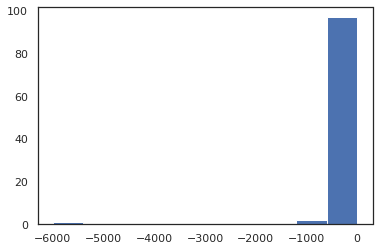

In [160]:
plt.hist(params.log_alpha)

In [165]:
params.w.argmax()

DeviceArray(124, dtype=int32)

(array([1.000e+00, 5.000e+00, 7.000e+00, 3.800e+01, 5.408e+03, 2.900e+01,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([-408.88934 , -316.64185 , -224.39435 , -132.14685 ,  -39.899353,
          52.348145,  144.59564 ,  236.84314 ,  329.09064 ,  421.33813 ,
         513.58563 ], dtype=float32),
 <BarContainer object of 10 artists>)

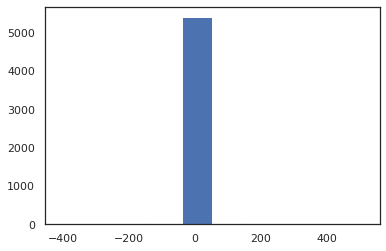

In [162]:
plt.hist(params.w.flatten())

In [28]:
# Run samplers
init_batch = dist.sample(100, seed=key)[:-1]
lmc_samples, lmc_logps = run_lmc(key, init_batch)
svgd_samples, svgd_logps = run_svgd(init_batch)
# neural_samples, neural_gradient, neural_particles = run_neural_svgd(key, init_batch)

100%|██████████| 9296/9296 [00:39<00:00, 237.73it/s]


## Evaluate samples on test set

In [30]:
def get_probs(params):
    """
    Argument: sampled model parameters (single sample! need to vmap over sample batch)
    Returns logits shaped (n,)"""
    test_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_test))
    dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
    probs = dists[-1].distribution.probs_parameter() # spits out probability of labels
    return probs

def get_preds(params):
    """
    Argument: sampled model parameters (batch)
    Returns predictions on test set
    """
    probs = vmap(get_probs)(params) # shape (n_samples, n_data)
    return (probs.mean(axis=0) > 0.5).astype(np.int32)

@jit
def test_accuracy(params):
    """
    Argument: sampled model parameters (batch)
    Returns accuracy on test set
    """
    return np.mean(get_preds(params) == y_test)

In [31]:
print("LMC accuracy:", test_accuracy(lmc_samples))
print("SVGD accuracy:", test_accuracy(svgd_samples))
key, subkey = random.split(key)
print("prior samples accuracy:", test_accuracy(dist.sample(500, seed=subkey)[:-1]))

LMC accuracy: 0.4862181
SVGD accuracy: 0.4862181
prior samples accuracy: 0.51462525


### compute test log-likelihood

In [32]:
test_batches = get_batches(x_test, y_test, batch_size=5000)

In [33]:
x, y = next(test_batches)
test_logp = get_logp(x, y)

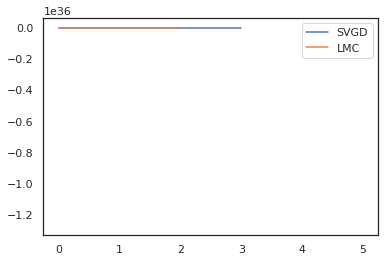

In [34]:
plt.plot(svgd_logps.mean(axis=1), label="SVGD");
plt.plot(lmc_logps.mean(axis=1), label="LMC");
plt.legend()

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib

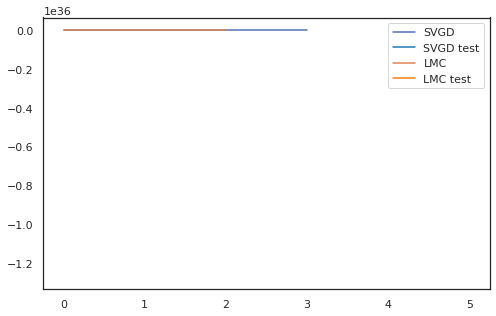

In [35]:
lmc_test_logp = np.mean(vmap(test_logp)(lmc_samples))
svgd_test_logp = np.mean(vmap(test_logp)(svgd_samples))

fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(svgd_logps.mean(axis=1), label="SVGD")
ax.axhline(y=svgd_test_logp, label="SVGD test", color="tab:blue")

ax.plot(lmc_logps.mean(axis=1), label="LMC")
ax.axhline(y=lmc_test_logp, label="LMC test", color="tab:orange")

plt.legend()